<a href="https://colab.research.google.com/github/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks/collections_demos/nlm_visible_human_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visible Human Project @ NCI Imaging Data Commons

National Library of Medicine **[Visible Human Project](https://www.nlm.nih.gov/research/visible/visible_human.html) dataset (VHD)** was released in 1994. Since then, VHD enabled [a large number of studies](https://scholar.google.com/scholar?cites=14936044487090373990&as_sdt=40000005&sciodt=0,22&hl=en), including development of the [Insight Toolkit](https://itk.org/) and its initial release in 2002 (check out this 2003 [publication by Michael Ackerman and Terry Yoo](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1480240/) for the historical perspective). For a long time, access to VHD required obtaining a license, but recently NLM lifted that requirement. While the access to the data was opened, [downloading it from the NLM website](https://data.lhncbc.nlm.nih.gov/public/Visible-Human/Male-Images/index.html) was somewhat suboptimal, and more importantly, radiology data was shared in a [proprietary format that predated DICOM](https://discourse.slicer.org/t/visible-human-project-mri-dataset-loading/8034/4), complicating its use.

In July 2023, VHD was included in the v15 data release by the [NCI Imaging Data Commons](https://portal.imaging.datacommons.cancer.gov/explore/filters/?collection_id=nlm_visible_human_project). With the release of VHD on IDC:
* VHD images are available harmonized into standard DICOM representation
* radiology images can be visualized directly in the browser using IDC Portal (e.g., see this [CT series](https://viewer.imaging.datacommons.cancer.gov/viewer/1.3.6.1.4.1.5962.1.2.370.1672334394.26545?SeriesInstanceUID=1.3.6.1.4.1.5962.1.3.370.2.1672334394.26545) of the Visible Female)
* metadata accompanying VHD is searchable
* image files are available from either Google Cloud Platform or AWS buckets, and can be downloaded efficiently at any level (e.g., as the entire collection, or individual DICOM series)

The IDC release of the VHD dataset includes both the radiology (CT and MR) and digitized cryosections images for both Visible Male and Visible Female. As part of data harmonization, images were converted into standard DICOM representation (from the original proprietary GE Signa format and PNG for the radiology and cryosection images, respectively), while maintaining the acquisition metadata in standard DICOM fields. Cryosection images are available as External Camera Photography (XC) modality DICOM series.

In this notebook we demonstrate interoperability and visualization of DICOM XC cryosection images using off-the-shelf open source tools.

If you have any questions about this notebook or VHD dataset on IDC, please post your questions on [IDC user forum](https://discourse.canceridc.dev/).

---

Initial release: July 2023

Updated: Sept 2024

Prepared by: Andrey Fedorov

## Introduction

This short notebook consists of two parts.

In the first part we download a single XC image from IDC, and demonstrate how to visualize it. You do not need to complete any prerequisites for this step.

In the second part, we demonstrate how to search IDC content and download arbitrary subsets of the dataset. You will need to complete basic prerequisites for that component.

This notebook has minimal prerequisites:
* `itk` python package to read the images
* [`idc-index`](https://github.com/imagingdatacommos/idc-index) package that simplifies interaction with IDC

In [1]:
%%capture
!pip install --upgrade itk idc-index

## Visualizing DICOM XC modality

Visible Human Dataset contains digitized cryosection images, which are stored as DICOM  External Camera Photography (XC). XC is not a commonly encountered modality. But at the same time, since it follows the conventions in other DICOM imaging modalities, it can be interpreted with zero or minimal extra effort by the existing toolkits to visualize individual slices.


To interact with IDC we need to instantiate `IDCClient`.

In [2]:
from idc_index import IDCClient

client = IDCClient()

Next we download a sample DICOM XC file from IDC AWS bucket. As part of `idc-index` installation, `s5cmd` package was installed as a prerequisite, and `client.s5cmdPath` contains the path to the `s5cmd` binary that we will use in the following cell.

In [3]:
sample_url = "s3://idc-open-data/56f8119f-5940-48c1-96ee-8d445dc0b5fd/5ad7d793-79ba-426e-a05e-5bf0eb0c1aa3.dcm"

!$client.s5cmdPath --no-sign-request --endpoint-url https://s3.amazonaws.com cp {sample_url} .

cp s3://idc-open-data/56f8119f-5940-48c1-96ee-8d445dc0b5fd/5ad7d793-79ba-426e-a05e-5bf0eb0c1aa3.dcm 5ad7d793-79ba-426e-a05e-5bf0eb0c1aa3.dcm


Loading those images requires a bit of work to instantiate the reader of the appropriate type (the `imread()` function does not recognize the pixel type correctly).

In [4]:
import itk

def load_dicom_xc_slice(file_name):
  # Set the pixel type explicitly as RGB
  PixelType = itk.RGBPixel[itk.UC]

  # Set the image dimension
  Dimension = 2

  # Specify the image type
  ImageType = itk.Image[PixelType, Dimension]

  # Create an instance of the image reader
  reader = itk.ImageFileReader[ImageType].New()

  # Set the file name to the reader
  reader.SetFileName(file_name)

  # Update the reader to read the image
  reader.Update()

  # Access the loaded image
  image = reader.GetOutput()

  return image


Next you can use standard `matplotlib` to view the RGB image.

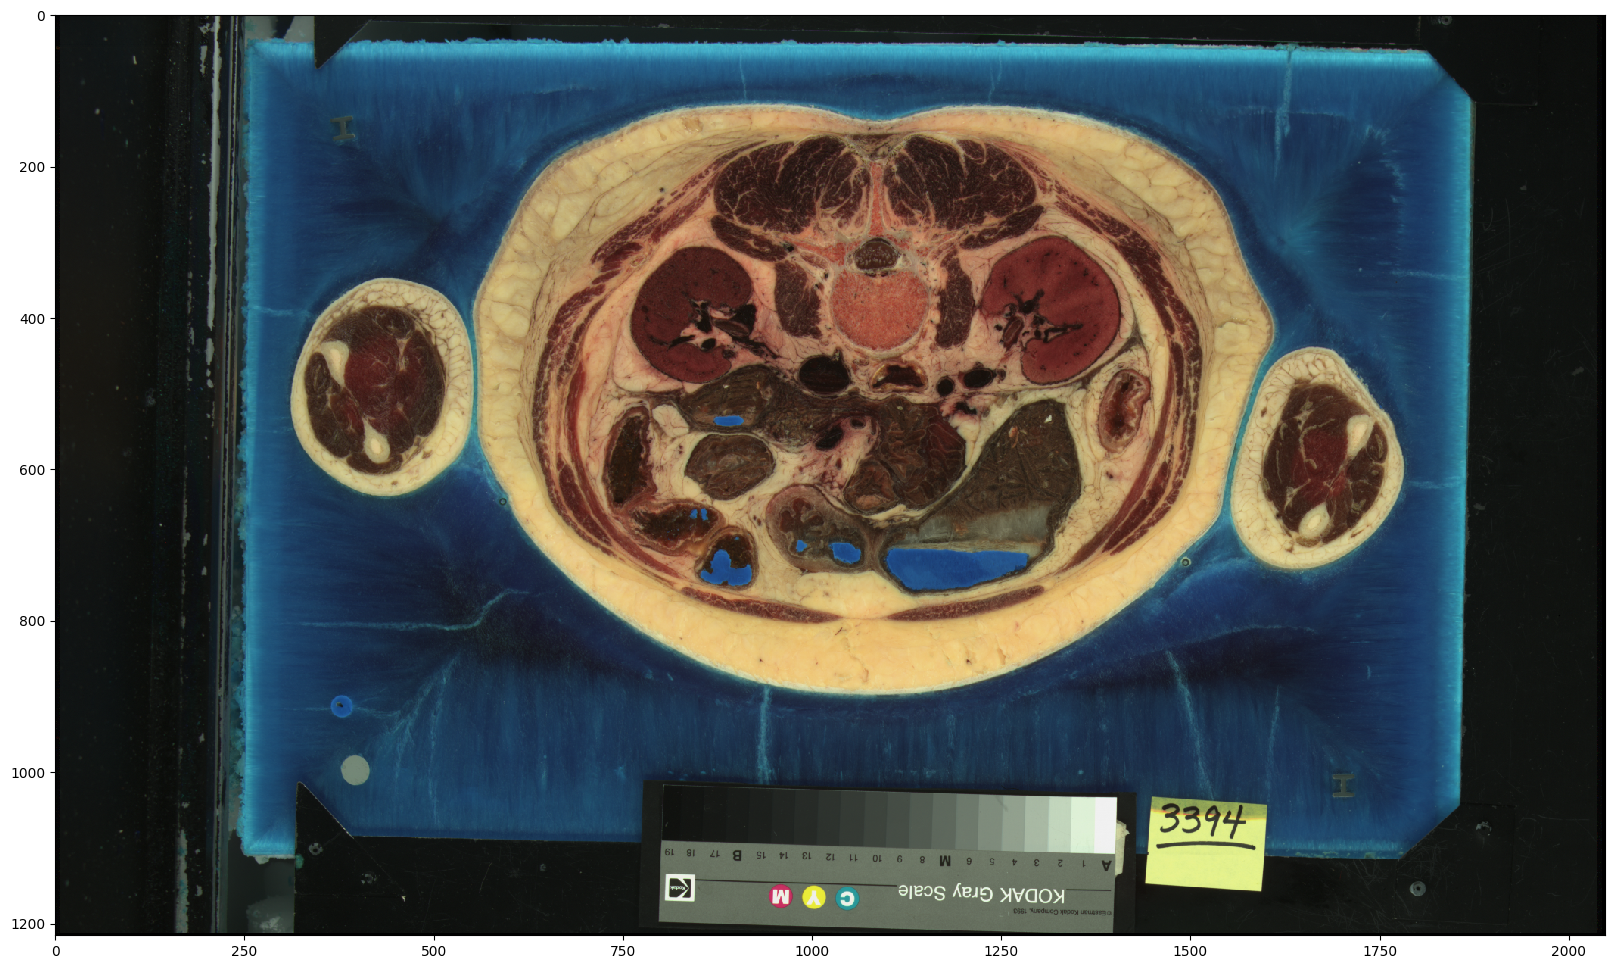

In [5]:
import matplotlib.pyplot as plt

image = load_dicom_xc_slice("/content/"+sample_url.split('/')[-1])

fig1 = plt.figure(figsize = (20,20))

ax1 = fig1.add_subplot()
ax1.imshow(image, interpolation='none')

plt.show()

It is important to note that VHD XC series contain spatial information not available in the original PNG images. Those attributes include `PixelSpacing`, and `ImagePositionPatient`, which can be used to reconstruct 3D volume from the tissue cryosections. We may add the examples of such 3D reconstruction to this notebook in the future!

## Exploring VHD

In this section we demonstrate how you can use `idc-index` and SQL to explore the content of the VHD dataset on IDC, and access its aribtrary components. If you have never used `idc-index` package before, you may want to go over the [getting started notebook](https://github.com/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks/getting_started/part2_searching_basics.ipynb) first!

As a first step, we can summarize the content of the VHD in terms of the patients, modalities and sizes of the individual components.

In [6]:
query = """
SELECT
  PatientID,
  Modality,
  SUM(series_size_MB/1000) AS modality_total_size_GB
FROM
  index
WHERE
  collection_id = 'nlm_visible_human_project'
GROUP BY
  PatientID,
  Modality
ORDER BY
  modality_total_size_GB desc
"""

result_df = client.sql_query(query)

result_df

PatientID Modality  modality_total_size_GB
0     VHP-F       XC               233.93844
1     VHP-M       XC                76.11159
2     VHP-M       CT                 1.26519
3     VHP-F       CT                 0.91225
4     VHP-M       MR                 0.12939
5     VHP-F       MR                 0.12276

You can see that the VHD collection contains 2 distinct patient ID values, corresponding to the Visible Male (VHP-M) and Visible Female (VHP-F), with XC modality corresponding to the largest components of the collection.

In the next query we query for the attributes of the VHD XC series.

In [7]:
query = """
SELECT
  PatientID,
  SeriesInstanceUID,
  ANY_VALUE(SeriesDescription),
  SUM(series_size_MB/1000) AS series_total_size_GB
FROM
  index
WHERE
  collection_id = 'nlm_visible_human_project'
  AND Modality = 'XC'
GROUP BY
  PatientID,
  SeriesInstanceUID
ORDER BY
  series_total_size_GB DESC
"""

result_df = client.sql_query(query)

result_df

PatientID                          SeriesInstanceUID  \
0     VHP-F   1.3.6.1.4.1.5962.1.3.0.2.1677425356.1733   
1     VHP-M  1.3.6.1.4.1.5962.1.3.0.2.1672334394.26545   
2     VHP-F   1.3.6.1.4.1.5962.1.3.0.1.1677425356.1733   
3     VHP-M  1.3.6.1.4.1.5962.1.3.0.1.1672334394.26545   

  any_value(SeriesDescription)  series_total_size_GB  
0        70mm film - digitized             195.18515  
1        70mm film - digitized              62.07808  
2   Fullcolor - direct digital              38.75329  
3   Fullcolor - direct digital              14.03351

Next, we retrieve S3 URLs for each of the instance of XC modality in this collection, this time using BigQuery python API.

In [8]:
query = """
SELECT
  PatientID,
  SeriesInstanceUID,
  series_aws_url,
  collection_id
FROM
  index
WHERE
  collection_id = 'nlm_visible_human_project'
  AND Modality = 'XC'
"""

result_df = client.sql_query(query)

result_df

PatientID                          SeriesInstanceUID  \
0     VHP-F   1.3.6.1.4.1.5962.1.3.0.2.1677425356.1733   
1     VHP-M  1.3.6.1.4.1.5962.1.3.0.2.1672334394.26545   
2     VHP-F   1.3.6.1.4.1.5962.1.3.0.1.1677425356.1733   
3     VHP-M  1.3.6.1.4.1.5962.1.3.0.1.1672334394.26545   

                                      series_aws_url  \
0  s3://idc-open-data/9a5382ad-338a-451f-aa6a-080...   
1  s3://idc-open-data/237eaf33-4162-4a9e-8212-7f1...   
2  s3://idc-open-data/56f8119f-5940-48c1-96ee-8d4...   
3  s3://idc-open-data/4aaf9181-fb6a-4a4c-bf49-d1e...   

               collection_id  
0  nlm_visible_human_project  
1  nlm_visible_human_project  
2  nlm_visible_human_project  
3  nlm_visible_human_project

You can download individual series by passing `SeriesInstanceUID` to either the command-line download interface (which was set up when we installed the `idc-index` package) ...

In [9]:
!idc download 1.3.6.1.4.1.5962.1.3.0.1.1672334394.26545

2024-09-16 18:04:26,518 - Downloading from IDC v19 index
2024-09-16 18:04:26,719 - Identified matching SeriesInstanceUID: ['1.3.6.1.4.1.5962.1.3.0.1.1672334394.26545']
2024-09-16 18:04:26,748 - Total size of files to download: 14.03 GB
2024-09-16 18:04:26,748 - Total free space on disk: 205.222449152GB
2024-09-16 18:04:26,905 - Not using s5cmd sync as the destination folder is empty or sync or progress bar is not requested
2024-09-16 18:04:26,906 - Initial size of the directory: 0 bytes
2024-09-16 18:04:26,906 - Approximate size of the files that need to be downloaded: 14033510000.0 bytes
Aborted!


... or programmatically using `IDCClient`:

In [ ]:
client.download_from_selection(seriesInstanceUID="1.3.6.1.4.1.5962.1.3.0.1.1672334394.26545", downloadDir=".")

Finally, in the following cell we download and visualize a random XC slice from the series.

To do that, we first get the list of URLs for all files included in the series, and then retrieve a random slice.

s3://idc-open-data/4aaf9181-fb6a-4a4c-bf49-d1eb9ed4a385/770cace8-aabf-4474-a70d-f23889bec103.dcm
cp s3://idc-open-data/4aaf9181-fb6a-4a4c-bf49-d1eb9ed4a385/770cace8-aabf-4474-a70d-f23889bec103.dcm 770cace8-aabf-4474-a70d-f23889bec103.dcm


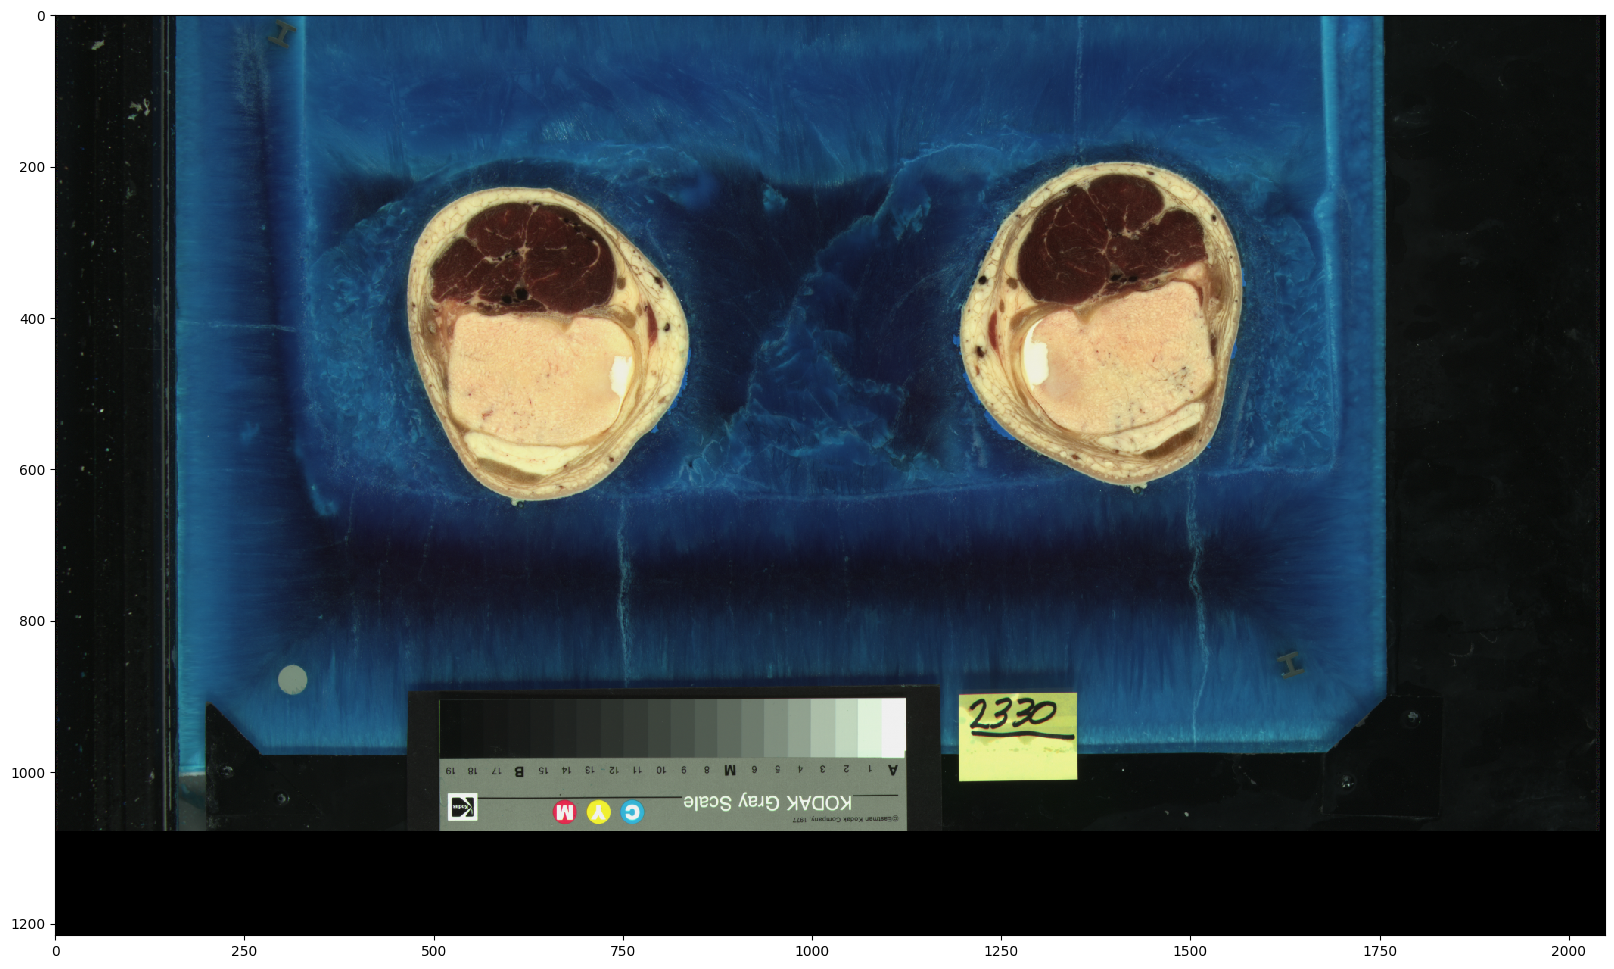

In [10]:
import random

slices = client.get_series_file_URLs(seriesInstanceUID="1.3.6.1.4.1.5962.1.3.0.1.1672334394.26545")

sample_slice = random.choice(slices)

print(sample_slice)

# download the file
!$client.s5cmdPath --no-sign-request --endpoint-url https://s3.amazonaws.com cp {sample_slice} .

image = load_dicom_xc_slice("./"+sample_slice.split("/")[-1])

fig1 = plt.figure(figsize = (20,20))
ax1 = fig1.add_subplot()
ax1.imshow(image, interpolation='none')

plt.show()

We hope you find VHD more accessible and easier to use with its release on IDC.

Enjoy it, and please reach out in [IDC forum](https://discourse.canceridc.dev) with any questions!

## Acknowledgments

Imaging Data Commons has been funded in whole or in part with Federal funds from the National Cancer Institute, National Institutes of Health, under Task Order No. HHSN26110071 under Contract No. HHSN261201500003l.

If you use IDC in your research, please cite the following publication:

> Fedorov, A., Longabaugh, W. J. R., Pot, D., Clunie, D. A., Pieper, S. D., Gibbs, D. L., Bridge, C., Herrmann, M. D., Homeyer, A., Lewis, R., Aerts, H. J. W., Krishnaswamy, D., Thiriveedhi, V. K., Ciausu, C., Schacherer, D. P., Bontempi, D., Pihl, T., Wagner, U., Farahani, K., Kim, E. & Kikinis, R. _National Cancer Institute Imaging Data Commons: Toward Transparency, Reproducibility, and Scalability in Imaging Artificial Intelligence_. RadioGraphics (2023). [https://doi.org/10.1148/rg.230180](https://doi.org/10.1148/rg.230180)